Features to be added!
7/7/23

1. Raw drawing import - scaling
2. Mask cleanup
3. Mask Optimization

In [1]:
#%%
# Updated 10/12/2023 by Michael Tan
# Utilized for importing DXF shapes (curated file), generating a mask, than outputting a dxf
# Parsing DXF
import ezdxf as ez
# Maths
import numpy as np
import pandas as pd
# Shapes
import shapely.geometry as spg
from shapely.ops import unary_union, polygonize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
import pandas
from descartes import PolygonPatch
from shapely import affinity
# Plotting
import pylab as pl
import matplotlib.pyplot as plt

# Misc
import os
import statistics
import geopandas as gpd
from sklearn.cluster import DBSCAN


In [2]:
class loaddxf():
    # This is a class object for loading a single DXF file
    def __init__(self,fn,scaledrawing=1):
        # Initialization
        self.fn = fn
        self.dbf = False #debug flag
        self.components = []
        self.cnames = []
        self.scaler = scaledrawing
        
    def loaddrawing(self):
        # Import DXF as a ezdxf object. 
        doc = ez.readfile(self.fn)
        msp = doc.modelspace()
        # Iterate through all items
        for e in msp:
            if self.dbf == True:
                print(e.dxf.layer)
                print(e.dxftype())
            # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
            if e.dxf.layer == 'PKG_OUTLINE':
                if e.dxftype() == 'LWPOLYLINE':
                    #print(e.vertices(),e.dxftype())
                    p = e.get_points()
                    # update later to add polygon
                    self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
                    #print("Package Outline: ")
                    self.pkgout
            # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
            elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
                if e.dxftype() == 'SOLID':
                    if self.dbf == True:
                        print(e.dxf.handle)
                        print(e.vertices())
                    self.cnames.append(e.dxf.handle)
                    self.components.append(e.vertices())
        print(str(len(self.components)) + " objects have been found on BSR layer.")
        
    def maptodataframe(self):
        # Using the solid objects encountered, parse into a dataframe or 2.
        P1X,P1Y = [],[]
        P2X,P2Y = [],[]
        P3X,P3Y = [],[]
        P4X,P4Y = [],[]
        CX,CY = [],[]
        for comp in self.components:
            # Identify point# 1 - bottom left corner
            P1X.append(comp[0][0]*self.scaler)
            P1Y.append(comp[0][1]*self.scaler)
            P3X.append(comp[2][0]*self.scaler)
            P3Y.append(comp[2][1]*self.scaler)
            P2X.append(comp[1][0]*self.scaler)
            P2Y.append(comp[1][1]*self.scaler)
            P4X.append(comp[3][0]*self.scaler)
            P4Y.append(comp[3][1]*self.scaler)
        # Sizes
        DX = np.subtract(P3X, P1X)
        DY = np.subtract(P3Y, P1Y)
        # Centers
        CX = np.add(P1X,DX/2)
        CY = np.add(P1Y,DY/2)
        # One DF with centers and corners
        self.df = pd.DataFrame({"CNAME":self.cnames,"X":CX,"Y":CY,"P1X":P1X,"P1Y":P1Y,"P3X":P3X,"P3Y":P3Y})
        self.df_full = pd.DataFrame({"CNAME":self.cnames,"X":CX,"Y":CY,"P1X":P1X,"P1Y":P1Y,
                                     "P2X":P2X,"P2Y":P2Y,
                                     "P3X":P3X,"P3Y":P3Y,
                                     "P4X":P4X,"P4Y":P4Y})
        df_m1 = pd.melt(self.df_full, id_vars=['CNAME'], value_vars=['P1X', 'P2X', "P3X", "P4X"], value_name = "X")
        df_m2 = pd.melt(self.df_full, id_vars=['CNAME'], value_vars=['P1Y', 'P2Y', "P3Y", "P4Y"], value_name = "Y")
        self.df_melt = pd.concat([df_m1,df_m2],axis=1)
        self.df_points = self.df_melt[['X','Y']].values.tolist()
        print("Completed mapping to dataframes df (center, size, corner points)")

    def maptolistofpoly(self):
        # This is messy for now. We take points than shove it into a box. It would be better to go from dxf vector to polygon.
        # Initialize an empty list
        self.pg_cmp = []
        for index, row in self.df.iterrows():
            p1 = (row.P1X,row.P1Y,row.P3X,row.P3Y)
            poly1 = spg.box(p1[0],p1[1],p1[2],p1[3])
            self.pg_cmp.append(poly1)
        print("pg_cmp is nominal position of all package components.")
            
    def process(self):
        # Load data
        self.loaddrawing()
        print("loaded raw drawing")
        # Map to dataframe
        self.maptodataframe()
        print("Mapped to dataframes")
        # Map to list of BOXES - no oversize. 
        self.maptolistofpoly()
        print("mapped to polygons")
        print("Completed loading all the data")
        
class generatemasks():
    # Class used to generate a mask
    def __init__(self,cmp,exp_cmp=0.65,exp_out=1):
        # Initialize some variables
        self.dbf = False #debug flag
        self.cmp = cmp
        # Variable to expand components - polygons are extended with a buffer function - magnitude
        self.exp_cmp = exp_cmp
        # Variable to expand outline - simple scaler/multiplier
        self.exp_out = exp_out
    
    def process_cmp_outline(self):
        # Create 3 masks: 
            # cmp_mask: component mask
            # cmp_out: component outline
            # diff_mask: Mask of the difference between outline & mask
        # Combine all smaller polygons & expand with exp_cmp
        bff_cmp = [x.buffer(self.exp_cmp).envelope.buffer(1).buffer(-1) for x in self.cmp]
        self.bff_cmp_mask = unary_union(bff_cmp)
        self.raw_cmp_mask = unary_union(self.cmp)
        print("generated outline")
    
    def process_cmp_interior(self):
        
        cmp_outline_mask = spg.box(self.bff_cmp_mask.bounds[0]-self.exp_out,self.bff_cmp_mask.bounds[1]-self.exp_out,
            self.bff_cmp_mask.bounds[2]+self.exp_out,self.bff_cmp_mask.bounds[3]+self.exp_out)#.buffer(1500)
        diff_mask = cmp_outline_mask.difference(self.bff_cmp_mask)
        
        if diff_mask.geom_type == 'MultiPolygon':
            self.interior_sup_mask = spg.MultiPolygon([P.buffer(1).buffer(-1).simplify(0.05) for P in diff_mask.geoms if P.area < 50])
            print("generated interior")
        elif diff_mask.geom_type == 'Polygon':
            self.interior_sup_mask = False
            print("No interior supports with single polygon")

    def process(self):
        print("Running mask script")
        self.process_cmp_outline()
        self.process_cmp_interior()
        print("created component mask with: Expand = " + str(self.exp_cmp) + " and " + str(self.exp_out) + "x outline.")
        print("cmp_mask is raw mask, cmp_out is outline mask, diff_mask is outline-component")
        print("Completed")
     
        
class plotfun():
    
    def __init__(self,pkgout,raw_cmp_mask, bff_cmp_mask, interior_sup_mask):
        # Initialize some variables
        self.dbf = False #debug flag
        self.raw_cmp_mask = raw_cmp_mask
        self.bff_cmp_mask = bff_cmp_mask
        self.interior_sup_mask = interior_sup_mask
        self.pkgout = pkgout
    
    def plotstuff(self):
        for geom in self.raw_cmp_mask.geoms:
            plt.plot(*geom.exterior.xy, color='gray')
        if type(self.raw_cmp_mask) == type(self.bff_cmp_mask):
            for geom in self.bff_cmp_mask.geoms:
                plt.plot(*geom.exterior.xy)
        else:
            plt.plot(*self.bff_cmp_mask.exterior.xy)
        if self.interior_sup_mask is not False:
            for geom in self.interior_sup_mask.geoms:
                plt.plot(*geom.exterior.xy)
        plt.plot(*self.pkgout.exterior.xy)
        # Set (current) axis to be equal before showing plot
        plt.gca().axis("equal")
        plt.show()
    
    def process(self):
        self.plotstuff()


In [57]:
print("loading a single file")
root = r"E:\Scripting\MACD\MACD\TCB"
# dxf = "M54481-001_BSR_r01.dxf"
# dxffile = r"E:\Scripting\MACD\MACD\TCB\Examples\raw\M59998-001_BSR_r01-Design Overlay.dxf"
# dxffile = r"E:\Scripting\MACD\MACD\TCB\Examples\raw\N10298-001_BSR_LLT_r01-Design Overlay.dxf" # 2 rectangle shape
# dxffile=  r"E:\Scripting\MACD\MACD\TCB\Examples\raw\N12687-001_BSR_LLT_r01-Design Overlay.dxf"
# dxffile = os.path.join(root,"Examples","raw",dxf)
dxffile = r"E:\Scripting\MACD\MACD\TCB\Examples\raw\M83192-001_BSR_r01 - Design Overlay.dxf"
print("File to process: " + dxffile)
rawdxf = loaddxf(dxffile,scaledrawing=0.001)
rawdxf.process()
# print("Generated pg_cmp, df, df_melt, and df_points")
# maskset = generatemasks(rawdxf.pg_cmp, 0.65)
# maskset.process()
# plotme = plotfun(rawdxf.pkgout,maskset.raw_cmp_mask, maskset.bff_cmp_mask, maskset.interior_sup_mask)
# plotme.process()

loading a single file
File to process: E:\Scripting\MACD\MACD\TCB\Examples\raw\M83192-001_BSR_r01 - Design Overlay.dxf
976 objects have been found on BSR layer.
loaded raw drawing
Completed mapping to dataframes df (center, size, corner points)
Mapped to dataframes
pg_cmp is nominal position of all package components.
mapped to polygons
Completed loading all the data


In [58]:

def cavitygrouping(pgrp):
    df = gpd.GeoDataFrame(geometry=pgrp)
    # preparation for dbscan
    df['x'] = df['geometry'].centroid.x
    df['y'] = df['geometry'].centroid.y
    coords = df[["x", "y"]].to_numpy()

    EPS_DISTANCE = 6
    dbscan = DBSCAN(eps=EPS_DISTANCE, min_samples=1)
    clusters = dbscan.fit(coords)
    labels = pd.Series(clusters.labels_).rename('cavityID')
    df = pd.concat([df, labels], axis=1)
    # print(df)
    #list of interior clusters
    dflist = []
    
    for cavityN in df['cavityID'].unique():
        print("Generating clusters in cavityID: " + str(cavityN))
        dftemp = df.loc[df['cavityID']==cavityN].reset_index(drop=True)
        coords = dftemp[["x", "y"]].to_numpy()

        EPS_DISTANCE = 1
        dbscan = DBSCAN(eps=EPS_DISTANCE, min_samples=1)
        clusters = dbscan.fit(coords)
        labels = pd.Series(clusters.labels_).rename('interiorID')
        dftemp = pd.concat([dftemp, labels], axis=1)
        dflist.append(dftemp)
        # print(dflist)
    
    if len(dflist) > 1:
        dfall = pd.concat(dflist,axis=0).reset_index(drop=True)
        df_clusters = dfall.groupby(['cavityID', 'interiorID']).size().reset_index(name='Freq')
        print(df_clusters)
    else:
        dfall = dftemp

    return(dfall)

pgrp = rawdxf.pg_cmp
df = cavitygrouping(pgrp)



Generating clusters in cavityID: 0
Generating clusters in cavityID: 1
   cavityID  interiorID  Freq
0         0           0   248
1         0           1   218
2         0           2    22
3         1           0   248
4         1           1   218
5         1           2    22


In [59]:
pgrp = rawdxf.pg_cmp
df = cavitygrouping(pgrp)


Generating clusters in cavityID: 0
Generating clusters in cavityID: 1
   cavityID  interiorID  Freq
0         0           0   248
1         0           1   218
2         0           2    22
3         1           0   248
4         1           1   218
5         1           2    22


These are the minimum distances observed from component to cutout exterior for CavityID: 0
Left side: 0.4
Bottom side: 0.4
Right side: 0.4
Top side: 0.4
These are the minimum distances observed from component to cutout exterior for CavityID: 1
Left side: 0.65
Bottom side: 0.65
Right side: 0.65
Top side: 0.65


(-21.3081, 22.1221, -12.596800000000002, 12.346800000000002)

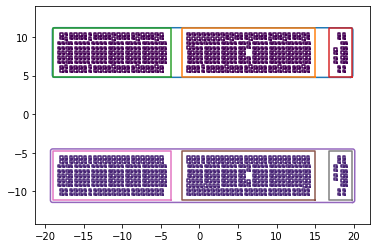

In [62]:
import matplotlib
import matplotlib.cm as cm
# cmin = min(clusters.labels_)
# cmax = max(clusters.labels_)
norm = matplotlib.colors.Normalize(vmin=0, vmax=10, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
boxmargin = 0.3

cavityboxes = []
subgroupboxes = []
interiorboxes = []

# colors = ['red', 'blue', 'green', 'orange']
for cmpgrp in df['cavityID'].unique():
    # Routine for Cavity
    bboxdf = df['geometry'].loc[df['cavityID']==cmpgrp].bounds
    cavitybox = spg.box(bboxdf.min()['minx']-boxmargin,bboxdf.min()['miny']-boxmargin,
                    bboxdf.max()['maxx']+boxmargin,bboxdf.max()['maxy']+boxmargin)
    cavityboxc = cavitybox.buffer(0.3,64)
    print("These are the minimum distances observed from component to cutout exterior for CavityID: " + str(cmpgrp))
    print("Left side: " + str(round(min(bboxdf['minx']-cavityboxc.bounds[0]),4)))
    print("Bottom side: " + str(round(min(bboxdf['miny']-cavityboxc.bounds[1]),4)))
    print("Right side: " + str(round(min(cavityboxc.bounds[2]-bboxdf['maxx']),4)))
    print("Top side: " + str(round(min(cavityboxc.bounds[3]-bboxdf['maxy']),4)))
    plt.plot(*cavityboxc.exterior.xy)
    for geom in df['geometry'].loc[df['cavityID']==cmpgrp]:
        plt.plot(*geom.exterior.xy, color = mapper.to_rgba(cmpgrp))
    # for geom in df['geometry'].loc[df['IslandID']==0]:
    #     plt.plot(*geom.exterior.xy, color = 'red')
    cavityboxes.append(cavityboxc)
    # Routine for interiors
    subgroupboxes = []
    for cmpsubgrp in df['interiorID'].loc[df['cavityID']==cmpgrp].unique():
        # print(cmpgrp)
        # print(cmpsubgrp)
        boxmargin = 0.65
        subgrppts = df['geometry'].loc[(df['interiorID']==cmpsubgrp) & (df['cavityID']==cmpgrp)].bounds
        subgrpbox = spg.box(subgrppts.min()['minx']-boxmargin,subgrppts.min()['miny']-boxmargin,
                            subgrppts.max()['maxx']+boxmargin,subgrppts.max()['maxy']+boxmargin)
        # print(subgrppts)
        plt.plot(*subgrpbox.exterior.xy)
        subgroupboxes.append(subgrpbox)
    # tempbox = unary_union(subgroupboxes)
    
    
    # tempbox = unary_union(pgrpbuff)
    # # print(tempbox)
    # # for temp in tempbox:
    # #     plt.plot(*temp.exterior.xy)
    # # plt.plot(*tempbox.exterior.xy)
    # interiors = cavitybox.buffer(-.2).difference(tempbox)
    # # plt.plot(*interiors.exterior.xy)
    # intsupport = interiors.buffer(-.6).buffer(.3,64)
    # # plt.plot(*intsupport.exterior.xy)

    # interiorboxes.append(interiors)
plt.gca().axis("equal")
# interiorboxes[0]

In [678]:
tf = [x.area > 2 for x in pgrpbuff]

In [11]:
from itertools import compress
pgrpsmall = list(compress(pgrpbuff, tf))

NameError: name 'pgrpbuff' is not defined

In [50]:
from itertools import compress

pgrpbuff = [x.buffer(.7).envelope for x in pgrp]
tempmask = cavitybox.buffer(-.2).difference(unary_union(pgrpbuff))
temp = list(compress(tempmask, [x.area > 0.5 for x in tempmask])) 

(-12.7895752, 11.515479200000001, -4.8626255, 6.642395499999998)

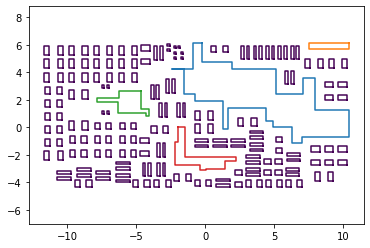

In [51]:
for geom in df['geometry'].loc[df['cavityID']==0]:
    plt.plot(*geom.exterior.xy, color = mapper.to_rgba(0))
for poly in temp:
    plt.plot(*poly.exterior.xy)
plt.gca().axis("equal")

In [269]:
df = gpd.GeoDataFrame(geometry=rawdxf.pg_cmp)

# preparation for dbscan
df['x'] = df['geometry'].centroid.x
df['y'] = df['geometry'].centroid.y
coords = df[["x", "y"]].to_numpy()

EPS_DISTANCE = 6
MIN_SAMPLE_POLYGONS = 1
dbscan = DBSCAN(eps=EPS_DISTANCE, min_samples=MIN_SAMPLE_POLYGONS)
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_).rename('IslandID')
df = pd.concat([df, labels], axis=1)


In [499]:
import matplotlib
import matplotlib.cm as cm
cmin = min(clusters.labels_)
cmax = max(clusters.labels_)
norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
boxmargin = 0.3

allboxes = []

# colors = ['red', 'blue', 'green', 'orange']
for cmpgrp in df['IslandID'].unique():
    bboxdf = df['geometry'].loc[df['IslandID']==cmpgrp].bounds
    bboxl = spg.box(bboxdf.min()['minx']-boxmargin,bboxdf.min()['miny']-boxmargin,
                    bboxdf.max()['maxx']+boxmargin,bboxdf.max()['maxy']+boxmargin).buffer(0.3,64)
    print("These are the minimum distances observed from component to cutout exterior:")
    print("Left side: " + str(min(bboxdf['minx']-bboxl.bounds[0])))
    print("Bottom side: " + str(min(bboxdf['miny']-bboxl.bounds[1])))
    print("Right side: " + str(min(bboxl.bounds[2]-bboxdf['maxx'])))
    print("Top side: " + str(min(bboxl.bounds[3]-bboxdf['maxy'])))
    plt.plot(*bboxl.exterior.xy)
    for geom in df['geometry'].loc[df['IslandID']==cmpgrp]:
        plt.plot(*geom.exterior.xy, color = mapper.to_rgba(cmpgrp))
    # for geom in df['geometry'].loc[df['IslandID']==0]:
    #     plt.plot(*geom.exterior.xy, color = 'red')
    allboxes.append(bboxl)
plt.gca().axis("equal")

KeyError: 'IslandID'

In [304]:
dlist = []

In [306]:
# Interiors:
# preparation for dbscan
# df['x'] = df['geometry'].centroid.x
# df['y'] = df['geometry'].centroid.y
dfint = df.loc[df['IslandID']==1].reset_index(drop=True)
coords = dfint[["x", "y"]].to_numpy()

EPS_DISTANCE = 3
MIN_SAMPLE_POLYGONS = 1
dbscan = DBSCAN(eps=EPS_DISTANCE, min_samples=MIN_SAMPLE_POLYGONS)
clusters = dbscan.fit(coords)
labels = pd.Series(clusters.labels_).rename('Interior_IslandID')
dfint = pd.concat([dfint, labels], axis=1)
dlist.append(dfint)
print(dfint)

                                              geometry          x         y  \
0    POLYGON ((9.31642 -7.92001, 9.31642 -7.62001, ...   9.156424 -7.770008   
1    POLYGON ((9.31642 -7.42001, 9.31642 -7.12001, ...   9.156424 -7.270008   
2    POLYGON ((3.56642 -7.92001, 3.56642 -7.62001, ...   3.406424 -7.770008   
3    POLYGON ((3.56642 -7.42001, 3.56642 -7.12001, ...   3.406424 -7.270008   
4    POLYGON ((10.45642 -7.92001, 10.45642 -7.62001...  10.296424 -7.770008   
..                                                 ...        ...       ...   
253  POLYGON ((13.30642 -5.09800, 13.30642 -4.79800...  13.146424 -4.947996   
254  POLYGON ((-2.35354 -4.59800, -2.35354 -4.29800...  -2.513542 -4.447996   
255  POLYGON ((-2.35354 -5.09800, -2.35354 -4.79800...  -2.513542 -4.947996   
256  POLYGON ((-8.05354 -4.59800, -8.05354 -4.29800...  -8.213542 -4.447996   
257  POLYGON ((-8.05354 -5.09800, -8.05354 -4.79800...  -8.213542 -4.947996   

     IslandID  Interior_IslandID  
0           1   

In [307]:
dfall = pd.concat(dlist,axis=0).reset_index(drop=True)
dfall

,geometry,x,y,IslandID,Interior_IslandID
0,"POLYGON ((-2.76354 5.35940, -2.76354 5.67940, ...",-2.913542,5.519404,0,0
1,"POLYGON ((-3.26354 5.35940, -3.26354 5.67940, ...",-3.413542,5.519404,0,0
2,"POLYGON ((11.09642 5.92940, 11.09642 6.24940, ...",10.946424,6.089404,0,1
3,"POLYGON ((11.59642 5.92940, 11.59642 6.24940, ...",11.446424,6.089404,0,1
4,"POLYGON ((12.64642 6.49940, 12.64642 6.81940, ...",12.496424,6.659404,0,1
...,...,...,...,...,...
511,"POLYGON ((13.30642 -5.09800, 13.30642 -4.79800...",13.146424,-4.947996,1,0
512,"POLYGON ((-2.35354 -4.59800, -2.35354 -4.29800...",-2.513542,-4.447996,1,1
513,"POLYGON ((-2.35354 -5.09800, -2.35354 -4.79800...",-2.513542,-4.947996,1,1
514,"POLYGON ((-8.05354 -4.59800, -8.05354 -4.29800...",-8.213542,-4.447996,1,1


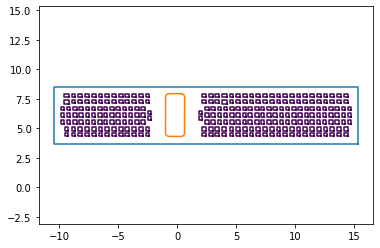

In [448]:
boxmargin = 0.6
holeboxpts = dfall['geometry'].loc[dfall['IslandID']==0].bounds
holebox = spg.box(holeboxpts.min()['minx']-boxmargin,holeboxpts.min()['miny']-boxmargin,
                    holeboxpts.max()['maxx']+boxmargin,holeboxpts.max()['maxy']+boxmargin)
groupbox1pts = dfall['geometry'].loc[(dfall['Interior_IslandID']==0) & (dfall['IslandID']==0)].bounds
grpbox1 = spg.box(groupbox1pts.min()['minx']-boxmargin,groupbox1pts.min()['miny']-boxmargin,
                    groupbox1pts.max()['maxx']+boxmargin,groupbox1pts.max()['maxy']+boxmargin)
groupbox2pts = dfall['geometry'].loc[(dfall['Interior_IslandID']==1) & (dfall['IslandID']==0)].bounds
grpbox2 = spg.box(groupbox2pts.min()['minx']-boxmargin,groupbox2pts.min()['miny']-boxmargin,
                    groupbox2pts.max()['maxx']+boxmargin,groupbox2pts.max()['maxy']+boxmargin)
plt.plot(*holebox.exterior.xy)
# plt.plot(*grpbox1.exterior.xy)
# plt.plot(*grpbox2.exterior.xy)
for geom in dfall['geometry'].loc[dfall['IslandID']==0]:
    plt.plot(*geom.exterior.xy, color = mapper.to_rgba(0))
plt.gca().axis("equal")
tempbox = unary_union([grpbox1,grpbox2])
gaps = holebox.difference(tempbox)
intsupport = gaps.buffer(-.9).buffer(.3,64)
plt.plot(*intsupport.exterior.xy)


In [368]:
gaph = gaps.bounds[2]-gaps.bounds[0]
gapw = gaps.bounds[3]-gaps.bounds[1]
print(gaph)
print(gapw)

2.819966
4.822012000000001


In [ ]:
cavityar = holebox.bounds[2]-holebox.bounds[0] / holebox.bounds[3]-holebox.bounds[1]
print(cavityar)
gaph = gaps.bounds[2]-gaps.bounds[0]
gapw = gaps.bounds[3]-gaps.bounds[1]
gapar = gaph / gapw
gapa = gaph * gapw

12.87723317463616
Wide cavity
Gap area of [13.597909891592002] below 50mm^2 limit, no interior features
width or length are < 6mm, no splitting necessary
generating single support structure with 0.6 buffer
Gap area is: 13.597909891592002
Gap width is: 4.822012000000001
Gap height is: 2.819966
Gap AR is: 0.5848110705655646


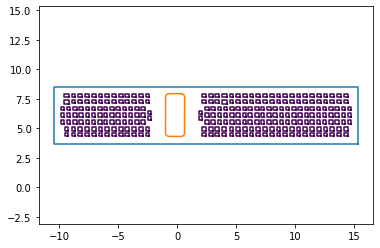

In [431]:


if cavityar > 1:
    print("Wide cavity")
    if gapa > 50:
        print("Gap area of ["+str(gapa)+"] exceeds 50mm^2 limit, generating supports")
    else:
        print("Gap area of ["+str(gapa)+"] below 50mm^2 limit, no interior features")
    if (gapw > 6) | (gaph > 6):
        print("Gap dimensions exceed maximum single support length or width with L: ["+str(gaph)+"] , W: ["+str(gapw)+"].")
        print("Splitting support")
        if cavityar > 1:
            print("Splitting into horizontal supports to align with cavity")
            

else:
    print("tall box")
islandgap = 1



if (gapw < 6) | (gaph < 6):
    print("width or length are < 6mm, no splitting necessary")
    print("generating single support structure with 0.6 buffer")
    intsupport = gaps.buffer(-.9).buffer(.3,64)
    
print("Gap area is: " + str(gaps.area))
print("Gap width is: " + str(gapw))
print("Gap height is: " + str(gaph))
print("Gap AR is: " + str(gapar))

plt.plot(*holebox.exterior.xy)
# plt.plot(*grpbox1.exterior.xy)
# plt.plot(*grpbox2.exterior.xy)
plt.plot(*intsupport.exterior.xy)
for geom in dfall['geometry'].loc[dfall['IslandID']==0]:
    plt.plot(*geom.exterior.xy, color = mapper.to_rgba(0))
plt.gca().axis("equal")
tempbox = unary_union([grpbox1,grpbox2])
gaps = holebox.difference(tempbox)
# plt.plot(*gaps.exterior.xy)

In [404]:
int(gapl)

15

In [430]:
import numpy as np
import math

supportwidth = 0.75

h = gaph
n_rows = int(gaph // supportwidth)
print(n_rows)

w = math.floor(gapw)
n_cols = 1
print(n_cols)

offset_x = w / n_cols
offset_y = h / n_rows

print(offset_y)
rectangles = []
intsups = []
for x in np.linspace(0, w, n_cols+1).tolist()[:-1]:
    for y in np.linspace(0, h, n_rows+1).tolist()[:-1]:
        x1 = int(round(x))
        x2 = int(round(x + offset_x))
        y1 = int(round(y))
        y2 = int(round(y + offset_y))
        supbox = spg.box(x1,y1,x2,y2)
        rectangles.append([(x1, y1), (x1, y2), (x2, y2), (x2, y1)])
        intsups.append(supbox)

print(rectangles)
print(intsups)

3
1
0.9399886666666667
[[(0, 0), (0, 1), (4, 1), (4, 0)], [(0, 1), (0, 2), (4, 2), (4, 1)], [(0, 2), (0, 3), (4, 3), (4, 2)]]
[<shapely.geometry.polygon.Polygon object at 0x000001A7588654E0>, <shapely.geometry.polygon.Polygon object at 0x000001A7588656D8>, <shapely.geometry.polygon.Polygon object at 0x000001A758865710>]


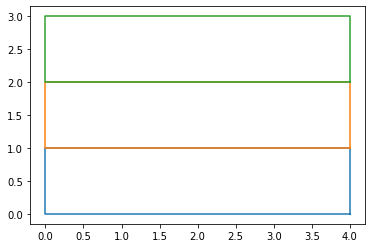

In [429]:
for sup in intsups:
    plt.plot(*sup.exterior.xy)


In [436]:
import shapely.wkt, shapely.geometry
import geopandas as gpd
import numpy as np
import pandas as pd

def rect(polygon, n=None, size=None, tol=0, clip=True, include_poly=False):
    assert (n is None and size is not None) or (n is not None and size is None)

    a, b, c, d = gpd.GeoSeries(polygon).total_bounds
    if not n is None:
        xa = np.linspace(a, c, n + 1)
        ya = np.linspace(b, d, n + 1)
    else:
        xa = np.arange(a, c + 1, size[0])
        ya = np.arange(b, d + 1, size[1])

    # offsets for tolerance
    if tol != 0:
        tol_xa = np.arange(0, tol * len(xa), tol)
        tol_ya = np.arange(0, tol * len(ya), tol)

    else:
        tol_xa = np.zeros(len(xa))
        tol_ya = np.zeros(len(ya))

    # combine placements of x&y with tolerance
    xat = np.repeat(xa, 2)[1:] + np.repeat(tol_xa, 2)[:-1]
    yat = np.repeat(ya, 2)[1:] + np.repeat(tol_ya, 2)[:-1]

    # create a grid
    grid = gpd.GeoSeries(
        [
            shapely.geometry.box(minx, miny, maxx, maxy)
            for minx, maxx in xat[:-1].reshape(len(xa) - 1, 2)
            for miny, maxy in yat[:-1].reshape(len(ya) - 1, 2)
        ]
    )

    # make sure all returned polygons are within boundary
    if clip:
        # grid = grid.loc[grid.within(gpd.GeoSeries(np.repeat([polygon], len(grid))))]
        grid = gpd.sjoin(
            gpd.GeoDataFrame(geometry=grid),
            gpd.GeoDataFrame(geometry=[polygon]),
            how="inner"
            # predicate="within"
        )["geometry"]
    # useful for visualisation
    if include_poly:
        grid = pd.concat(
            [
                grid,
                gpd.GeoSeries(
                    polygon.geoms
                    if isinstance(polygon, shapely.geometry.MultiPolygon)
                    else polygon
                ),
            ]
        )
    return grid

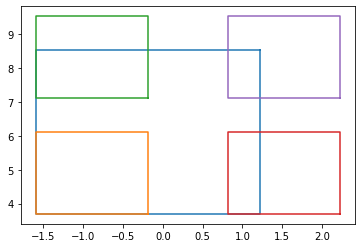

(-1.7845402999999997, 2.4174223, 3.4062914, 9.810504600000002)

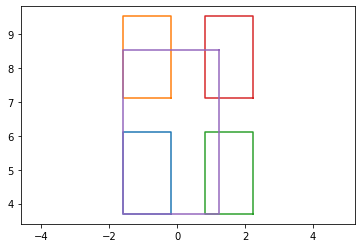

In [447]:
islands = rect(gaps, n=2, tol=1, clip=True, include_poly=True)
# plt.plot(*gaps.exterior.xy)
for sup in islands:
    plt.plot(*sup.exterior.xy)
plt.gca().axis("equal")

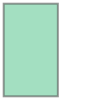

In [444]:
gaps

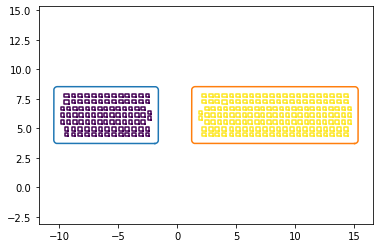

In [290]:
import matplotlib
import matplotlib.cm as cm
cmin = min(clusters.labels_)
cmax = max(clusters.labels_)
norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
boxmargin = 0.3

for cmpgrp in dfint['Interior_IslandID'].unique():
    bboxdf = dfint['geometry'].loc[dfint['Interior_IslandID']==cmpgrp].bounds
    bboxl = spg.box(bboxdf.min()['minx']-boxmargin,bboxdf.min()['miny']-boxmargin,
                    bboxdf.max()['maxx']+boxmargin,bboxdf.max()['maxy']+boxmargin).buffer(0.3,64)
    # print("These are the minimum distances observed from component to cutout exterior:")
    # print("Left side: " + str(min(bboxdf['minx']-bboxl.bounds[0])))
    # print("Bottom side: " + str(min(bboxdf['miny']-bboxl.bounds[1])))
    # print("Right side: " + str(min(bboxl.bounds[2]-bboxdf['maxx'])))
    # print("Top side: " + str(min(bboxl.bounds[3]-bboxdf['maxy'])))
    plt.plot(*bboxl.exterior.xy)
    for geom in dfint['geometry'].loc[dfint['Interior_IslandID']==cmpgrp]:
        plt.plot(*geom.exterior.xy, color = mapper.to_rgba(cmpgrp))
    # for geom in df['geometry'].loc[df['IslandID']==0]:
    #     plt.plot(*geom.exterior.xy, color = 'red')
    plt.gca().axis("equal")

In [66]:
class generatedxf():
    def __init__(self,fn,raw_cmp_mask,bff_cmp_mask,interior_sup_mask):
        self.fn = fn
        self.outfile = os.path.splitext(self.fn)[0]+"_jigstreet.dxf"
        self.raw_cmp_mask = raw_cmp_mask
        self.bff_cmp_mask = bff_cmp_mask
        self.interior_sup_mask = interior_sup_mask
    
    def addtodxf(self, pgroup):
        if pgroup.geom_type == 'Polygon':
            print("found polygon to add")
            dt = pd.DataFrame({"X":pgroup.exterior.coords.xy[0], "Y":pgroup.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            self.msp.add_lwpolyline(dt['xy'].tolist())
        elif pgroup.geom_type == 'MultiPolygon':
            print("found multi-polygon to add")
            for thispoly in pgroup:
                dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
                dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
                self.msp.add_lwpolyline(dt['xy'].tolist())
        else:
            print("Neither polygon nor multi-polygon. Cannot create jig file")

    def process(self):
        self.doc = ez.readfile(self.fn)
        self.msp = self.doc.modelspace()
        self.doc.layers.new("JIG_STREET")
        # self.addtodxf(self.raw_cmp_mask)
        self.addtodxf(self.bff_cmp_mask)
        self.addtodxf(self.interior_sup_mask)
        self.doc.saveas(self.outfile)
        print("Saved "+ str(self.outfile))   

In [67]:
outdxf = generatedxf(dxffile,maskset.raw_cmp_mask, maskset.bff_cmp_mask, maskset.interior_sup_mask)
outdxf.process()

found polygon to add
found multi-polygon to add
Saved E:\Scripting\MACD\MACD\TCB\Examples\M25268-001_BSR_LLT_r02-Scaled_jigstreet.dxf


In [42]:
def addtodxf(msp,pgroup):
    if pgroup.geom_type == 'Polygon':
        print("found polygon to add")
        dt = pd.DataFrame({"X":pgroup.exterior.coords.xy[0], "Y":pgroup.exterior.coords.xy[1]})
        dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
        msp.add_lwpolyline(dt['xy'].tolist())
    elif pgroup.geom_type == 'MultiPolygon':
        print("found multi-polygon to add")
        for thispoly in pgroup:
            dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            msp.add_lwpolyline(dt['xy'].tolist())
    else:
        print("Neither polygon nor multi-polygon. Cannot create jig file")


In [43]:
root = r"E:\Scripting\MACD\MACD\TCB"
dxf = r"M25268-001_BSR_LLT_r02-Scaled.dxf"
dxffile = os.path.join(root,"Examples",dxf)
doc = ez.readfile(dxffile)
msp = doc.modelspace()
doc.layers.new("JIG_STREET")

<class 'ezdxf.entities.layer.Layer'> LAYER(#37CE)

In [44]:
addtodxf(msp,maskset.raw_cmp_mask)
addtodxf(msp,maskset.bff_cmp_mask)
addtodxf(msp,maskset.interior_sup_mask)

found multi-polygon to add
found polygon to add
found multi-polygon to add


In [45]:
outfile = os.path.splitext(dxf)[0]+"_jigstreet.dxf"
print(outfile)
doc.saveas(outfile)

M25268-001_BSR_LLT_r02-Scaled_jigstreet.dxf


In [255]:
d = 0.00001 # distance
cf = 1.3  # cofactor
p = poly.buffer(-d).buffer(d*cf).intersection(poly).simplify(d)

TypeError: '<' not supported between instances of 'list' and 'int'

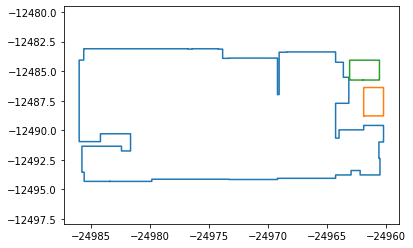

In [219]:
# Plot each polygon shape directly
# for geom in cmp_raw.geoms:
#     plt.plot(*geom.exterior.xy)
if type(cmp_raw) == type(diff_mask):
    for geom in diff_mask.geoms:
        plt.plot(*geom.exterior.xy)
else:
    plt.plot(*diff_mask.exterior.xy)
# Set (current) axis to be equal before showing plot
plt.gca().axis("equal")
plt.show()

In [30]:
class plotfun():
    # Function to make plotting just a little easier as I am lazy
    def __init__(self,pg_cmp,diff_poly,fs=(20,10)):
        self.dbf = False #debug flag
        self.fs = fs
        self.pg_cmp = pg_cmp
        self.diff_poly = diff_poly
        
    def plot_polygon(self,data):
        # Simple Function to plot polygons
        fig = pl.figure(figsize=self.fs)
        ax = fig.add_subplot(111)
        margin = 1
        x_min, y_min, x_max, y_max = data.bounds
        ax.set_xlim([x_min-margin, x_max+margin])
        ax.set_ylim([y_min-margin, y_max+margin])
        patch = PolygonPatch(data, fc='#999999', ec='#000000', fill=True, zorder=-1)
        ax.add_patch(patch)
        # fig = pl.plot(self.x,self.y,'o', color='#f16824')
        return fig
    
    # def plot_points(self):
    #     # Simple function to plot points ()
    #     fig = pl.figure(figsize=self.fs)
    #     fig = pl.plot(self.x,self.y,'o', color='#f16824')
    #     return fig
    
    def plot_results(self):
        # Simple function to plot everything together - components & difference mask
        fig = pl.figure(figsize=self.fs)
        ax = fig.add_subplot(111)
        margin = 1
        x_min, y_min, x_max, y_max = self.diff_poly.bounds
        ax.set_xlim([x_min-margin, x_max+margin])
        ax.set_ylim([y_min-margin, y_max+margin])
        patch1 = PolygonPatch(self.diff_poly, fc='green', ec='#000000', fill=True, zorder=-1)
        patch2 = PolygonPatch(unary_union(self.pg_cmp), fc='red', ec='#000000', fill=True, zorder=-1)
        ax.add_patch(patch1)
        ax.add_patch(patch2)
        ax.set_title('Masky mask doing mask things')
        # return fig

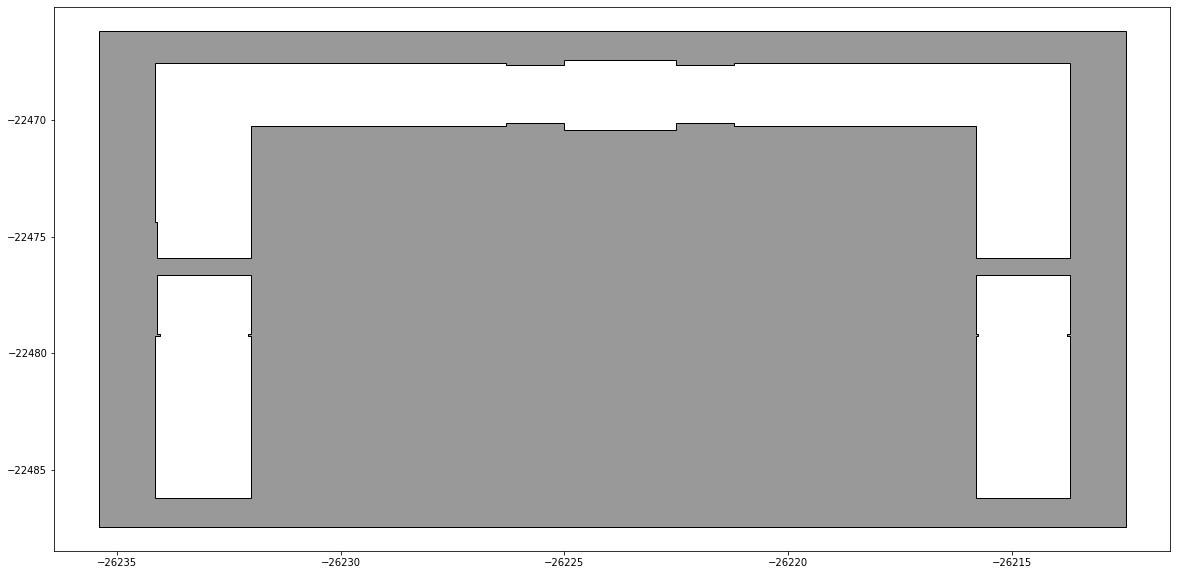

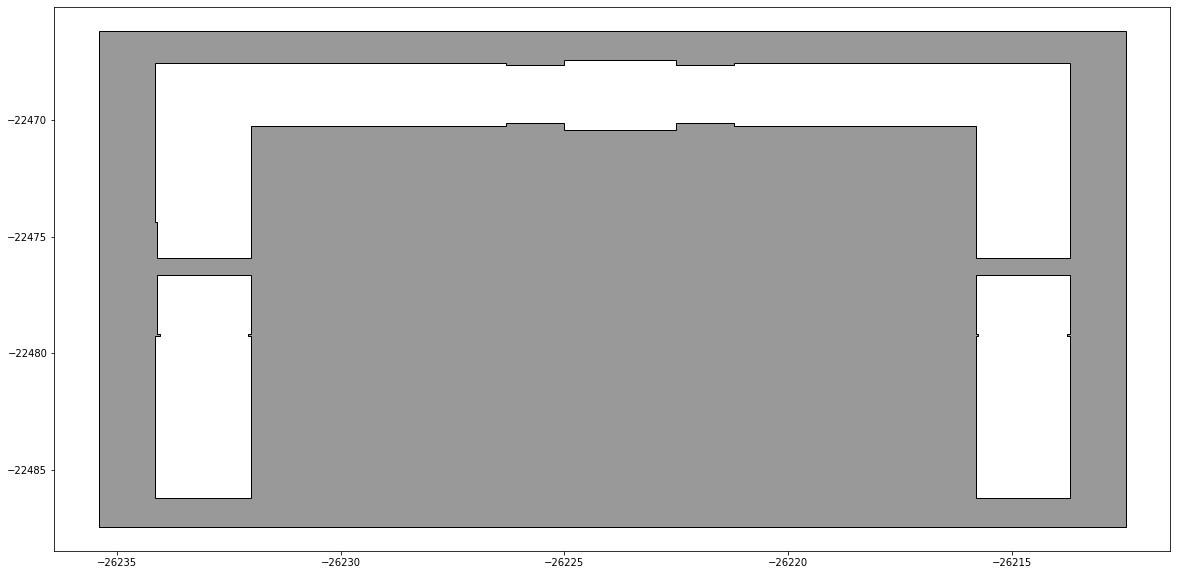

In [31]:
plotresults = plotfun(rawdxf.pg_cmp,maskset.diff_mask)
#plotresults.plot_results()
plotresults.plot_polygon(maskset.diff_mask)

In [23]:
# Load a file
root = r"E:\Scripting\MACD\MACD\TCB"
dxf = "M55024-001_BSR_r01-Scaled.dxf"
fn = os.path.join(root,"Examples",dxf)
rawdxf = loaddxf(os.path.join(root,"Examples",dxf),scaledrawing=0.01)



In [38]:
def processdxf(dxf,cmp_koz=0.5):
    dxffile = os.path.join(root,"Examples",dxf)
    print("File to process: " + dxffile)
    rawdxf = loaddxf(dxffile,scaledrawing=1)
    rawdxf.process()
    # cmp_koz = 0.35 # Scaler (POR is ~350 from speed or ~0.35 for scaled)
    group_koz = cmp_koz # OutlineAdder
    squarebound = True
    masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)#,squarebound)
    masks.process()
    plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
    plots.plot_results() # We input raw positions & generated masks into a plot together
    return ("Processed.")

In [53]:
dxffile = os.path.join(root,"Examples",dxf)
print("File to process: " + dxffile)
rawdxf = loaddxf(dxffile,scaledrawing=1)
rawdxf.process()
# cmp_koz = 0.35 # Scaler (POR is ~350 from speed or ~0.35 for scaled)
group_koz = cmp_koz # OutlineAdder
squarebound = True
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)#,squarebound)
masks.process()

File to process: E:\Scripting\MACD\MACD\TCB\Examples\M55024-001_BSR_r01-Scaled.dxf
220 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


In [20]:
#%%
# Created 7/5/2023 by Michael Tan & Josh Green
# Utilized for importing DXF shapes (curated file), generating a mask, than outputting a dxf
# Parsing DXF
import ezdxf as ez
# Maths
import numpy as np
import pandas as pd
# Shapes
import shapely.geometry as spg
from shapely.ops import unary_union, polygonize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
import pandas
from descartes import PolygonPatch
from shapely import affinity
# Plotting
import pylab as pl
# Misc
import os
import statistics

# %%
class loaddxf():
    # This is a class object for loading a single DXF file
    def __init__(self,fn,scaledrawing=1):
        # Initialization
        self.fn = fn
        self.dbf = False #debug flag
        self.components = []
        self.cnames = []
        self.scaler = scaledrawing
        
    def loaddrawing(self):
        # Import DXF as a ezdxf object. 
        doc = ez.readfile(self.fn)
        msp = doc.modelspace()
        # Iterate through all items
        for e in msp:
            if self.dbf == True:
                print(e.dxf.layer)
                print(e.dxftype())
            # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
            if e.dxf.layer == 'PKG_OUTLINE':
                if e.dxftype() == 'LWPOLYLINE':
                    #print(e.vertices(),e.dxftype())
                    p = e.get_points()
                    # update later to add polygon
                    self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
                    #print("Package Outline: ")
                    self.pkgout
            # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
            elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
                if e.dxftype() == 'SOLID':
                    if self.dbf == True:
                        print(e.dxf.handle)
                        print(e.vertices())
                    self.cnames.append(e.dxf.handle)
                    self.components.append(e.vertices())
        print(str(len(self.components)) + " objects have been found on BSR layer.")
        
    def maptodataframe(self):
        # Using the solid objects encountered, parse into a dataframe or 2.
        P1X,P1Y = [],[]
        P2X,P2Y = [],[]
        P3X,P3Y = [],[]
        P4X,P4Y = [],[]
        CX,CY = [],[]
        for comp in self.components:
            # Identify point# 1 - bottom left corner
            P1X.append(comp[0][0]*self.scaler)
            P1Y.append(comp[0][1]*self.scaler)
            P3X.append(comp[2][0]*self.scaler)
            P3Y.append(comp[2][1]*self.scaler)
            P2X.append(comp[1][0]*self.scaler)
            P2Y.append(comp[1][1]*self.scaler)
            P4X.append(comp[3][0]*self.scaler)
            P4Y.append(comp[3][1]*self.scaler)
        # Sizes
        DX = np.subtract(P3X, P1X)
        DY = np.subtract(P3Y, P1Y)
        # Centers
        CX = np.add(P1X,DX/2)
        CY = np.add(P1Y,DY/2)
        # One DF with centers and corners
        self.df = pd.DataFrame({"CNAME":self.cnames,"X":CX,"Y":CY,"P1X":P1X,"P1Y":P1Y,"P3X":P3X,"P3Y":P3Y})
        # self.dfs = pd.concat([pd.DataFrame({"X":P1X,"Y":P1Y}), pd.DataFrame({"X":P2X,"Y":P2Y}), pd.DataFrame({"X":P3X,"Y":P3Y}),
        #                         pd.DataFrame({"X":P4X,"Y":P4Y})]).reset_index(drop=True)
        # self.dfs = self.dfs.mul(self.poversize)
        print("Completed mapping to dataframes df (center, size, corner points)")

    def maptolistofpoly(self):
        # This is messy for now. We take points than shove it into a box. It would be better to go from dxf vector to polygon.
        # Initialize an empty list
        self.pg_cmp = []
        for index, row in self.df.iterrows():
            p1 = (row.P1X,row.P1Y,row.P3X,row.P3Y)
            poly1 = spg.box(p1[0],p1[1],p1[2],p1[3])
            self.pg_cmp.append(poly1)
        print("pg_cmp is nominal position of all package components.")
            
    def process(self):
        # Load data
        self.loaddrawing()
        # Map to dataframe
        self.maptodataframe()
        # Map to list of BOXES - no oversize. 
        self.maptolistofpoly()
        print("Completed loading all the data")
        
class generatemasks():
    # Class used to generate a mask
    def __init__(self,cmp,exp_cmp=1,exp_out=1.25,squarebound=True):
        # Initialize some variables
        self.dbf = False #debug flag
        self.cmp = cmp
        # Variable to expand components - polygons are extended with a buffer function - magnitude
        self.exp_cmp = exp_cmp
        # Variable to expand outline - simple scaler/multiplier
        self.exp_out = exp_out
        self.squarebound = squarebound
    
    def processcomp(self,expopt=False):
        # Create 3 masks: 
            # cmp_mask: component mask
            # cmp_out: component outline
            # diff_mask: Mask of the difference between outline & mask
        # Combine all smaller polygons & expand with exp_cmp
        if expopt == True:
            for i in np.arange(0.1, 0.8, 0.1):          
                pgroup = [x.buffer(i,8,2).envelope for x in self.cmp]
                cmp_mask = unary_union(pgroup)
                cmp_outline = spg.box(cmp_mask.bounds[0]-self.exp_out,cmp_mask.bounds[1]-self.exp_out,
                    cmp_mask.bounds[2]+self.exp_out,cmp_mask.bounds[3]+self.exp_out)#.buffer(1500)
                self.cmp_mask = cmp_mask
                self.cmp_out = cmp_outline
                # Create a difference mask between outline & smaller polygons
                self.diff_mask = cmp_outline.difference(cmp_mask)
                parea = [x.area for x in self.diff_mask]
                print("Loop at " + str(i))
                print(str(statistics.median(parea)))
                if statistics.median(parea) >=1:
                    print("Minimum small features detected. Buffer = "+str(i))
                    print(str(parea))
                    self.diff_mask = spg.MultiPolygon(list(filter(lambda x: x.area> 1, self.diff_mask)))
                    break

                
        else:
            if (self.squarebound==True):
                pgroup = [x.buffer(self.exp_cmp).envelope.simplify(1) for x in self.cmp]
            else:
                pgroup = [x.buffer(self.exp_cmp).simplify(1) for x in self.cmp]
            cmp_mask = unary_union(pgroup)
            # Create an outline using the cmp_mask X&Y Min/Max values
            cmp_outline = spg.box(cmp_mask.bounds[0]-self.exp_out,cmp_mask.bounds[1]-self.exp_out,
                            cmp_mask.bounds[2]+self.exp_out,cmp_mask.bounds[3]+self.exp_out)#.buffer(1500)
            self.cmp_mask = cmp_mask
            self.cmp_out = cmp_outline
            # Create a difference mask between outline & smaller polygons
            self.diff_mask = cmp_outline.difference(cmp_mask)
            print("created component mask with: Expand = " + str(self.exp_cmp) + " and " + str(self.exp_out) + "x outline.")

        
    def process(self):
        print("Running mask script")
        self.processcomp()
        print("Completed")
               
class plotfun():
    # Function to make plotting just a little easier as I am lazy
    def __init__(self,pg_cmp,diff_poly,fs=(20,10)):
        self.dbf = False #debug flag
        #plotscale= ((pkg_x/pkg_y)*20,(pkg_y/pkg_y)*20)
        self.fs = fs
        self.pg_cmp = pg_cmp
        self.diff_poly = diff_poly
        
    # def plot_polygon(self,data):
    #     # Simple Function to plot polygons
    #     fig = pl.figure(figsize=self.fs)
    #     ax = fig.add_subplot(111)
    #     margin = 1
    #     x_min, y_min, x_max, y_max = data.bounds
    #     ax.set_xlim([x_min-margin, x_max+margin])
    #     ax.set_ylim([y_min-margin, y_max+margin])
    #     patch = PolygonPatch(data, fc='#999999', ec='#000000', fill=True, zorder=-1)
    #     ax.add_patch(patch)
    #     fig = pl.plot(self.x,self.y,'o', color='#f16824')
    #     return fig
    
    # def plot_points(self):
    #     # Simple function to plot points ()
    #     fig = pl.figure(figsize=self.fs)
    #     fig = pl.plot(self.x,self.y,'o', color='#f16824')
    #     return fig
    
    def plot_results(self):
        # Simple function to plot everything together - components & difference mask
        fig = pl.figure(figsize=self.fs)
        ax = fig.add_subplot(111)
        margin = 1
        x_min, y_min, x_max, y_max = self.diff_poly.bounds
        ax.set_xlim([x_min-margin, x_max+margin])
        ax.set_ylim([y_min-margin, y_max+margin])
        patch1 = PolygonPatch(self.diff_poly, fc='green', ec='#000000', fill=True, zorder=-1)
        patch2 = PolygonPatch(unary_union(self.pg_cmp), fc='red', ec='#000000', fill=True, zorder=-1)
        ax.add_patch(patch1)
        ax.add_patch(patch2)
        ax.set_title('Masky mask doing mask things')
        # return fig
    
    # Temp
    # boundary = gpd.GeoSeries(cmp_mask)
    # outline = gpd.GeoSeries(cmp_outline)
    # diff = gpd.GeoSeries(diff_poly)
    
class generatedxf():
    def __init__(self,fn,cmp_mask,diff_mask):
        self.outfile = os.path.splitext(fn)[0]+"_jigstreet.dxf"
        self.cmp_mask = cmp_mask
        self.diff_mask = diff_mask
    
    def addoutline(self):
        for thispoly in self.cmp_mask:
            dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            self.msp.add_lwpolyline(dt['xy'].tolist())
    
    def addholes(self):
        for thispoly in self.diff_mask:
            dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            self.msp.add_lwpolyline(dt['xy'].tolist())

    def process(self):
        self.doc = ez.readfile(fn)
        self.msp = self.doc.modelspace()
        self.doc.layers.new("JIG_STREET")
        self.addoutline()
        self.addholes()
        self.doc.saveas(self.outfile)
        print("Saved "+ str(self.outfile))   
#%%
# if __name__ == "__main__":
#     # Main script to run
#     fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M55024-001_BSR_r01.dxf"
#     # fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
#     # fn = r"E:\Scripting\dxf\input_example.dxf"
#     rawdxf = loaddxf(fn)
#     rawdxf.process()
#     cmp_koz = 0.5 # Scaler
#     group_koz = 1 # Adder
#     masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
#     masks.process()
#     plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
#     plots.plot_results() # We input raw positions & generated masks into a plot together
#     # %%
#     woof = generatedxf(fn,masks.cmp_mask,masks.diff_mask)
#     woof.process()

 # %%
 


In [2]:
def processdxf(dxf,cmp_koz=0.5):
    dxffile = os.path.join(root,"Examples",dxf)
    print("File to process: " + dxffile)
    rawdxf = loaddxf(dxffile,scaledrawing=0.01)
    rawdxf.process()
    # cmp_koz = 0.35 # Scaler (POR is ~350 from speed or ~0.35 for scaled)
    group_koz = cmp_koz # OutlineAdder
    squarebound = True
    masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz,squarebound)
    masks.process()
    plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
    plots.plot_results() # We input raw positions & generated masks into a plot together
    return ("Processed.")

In [3]:
    def loaddrawing(self):
        # Import DXF as a ezdxf object. 
        doc = ez.readfile(self.fn)
        msp = doc.modelspace()
        # Iterate through all items
        for e in msp:
            if self.dbf == True:
                print(e.dxf.layer)
                print(e.dxftype())
            # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
            if e.dxf.layer == 'PKG_OUTLINE':
                if e.dxftype() == 'LWPOLYLINE':
                    #print(e.vertices(),e.dxftype())
                    p = e.get_points()
                    # update later to add polygon
                    self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
                    #print("Package Outline: ")
                    self.pkg_x = max(self.pkgout.boundary.coords.xy[0])-min(self.pkgout.boundary.coords.xy[0])
                    self.pkg_y = max(self.pkgout.boundary.coords.xy[1])-min(self.pkgout.boundary.coords.xy[1])
            # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
            elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
                if e.dxftype() == 'SOLID':
                    if self.dbf == True:
                        print(e.dxf.handle)
                        print(e.vertices())
                    self.cnames.append(e.dxf.handle)
                    self.components.append(e.vertices())
        print(str(len(self.components)) + " objects have been found on BSR layer.")

In [8]:
root = r"E:\Scripting\MACD\MACD\TCB"
dxf = "M55024-001_BSR_r01-Scaled.dxf"

In [9]:
fn = os.path.join(root,"Examples",dxf)
doc = ez.readfile(fn)
msp = doc.modelspace()

In [10]:
for e in msp:
    if e.dxf.layer == 'PKG_OUTLINE':
        print(e.dxf.layer)
        print(e.dxftype())
        p = e.get_points()
        pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])

PKG_OUTLINE
LWPOLYLINE


In [11]:
for e in msp:
    # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
    if e.dxf.layer == 'PKG_OUTLINE':
        if e.dxftype() == 'LWPOLYLINE':
            #print(e.vertices(),e.dxftype())
            p = e.get_points()
            # update later to add polygon
            self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
            #print("Package Outline: ")
            self.pkg_x = max(self.pkgout.boundary.coords.xy[0])-min(self.pkgout.boundary.coords.xy[0])
            self.pkg_y = max(self.pkgout.boundary.coords.xy[1])-min(self.pkgout.boundary.coords.xy[1])
    # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
    elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
        if e.dxftype() == 'SOLID':
            if self.dbf == True:
                print(e.dxf.handle)
                print(e.vertices())
            self.cnames.append(e.dxf.handle)
            self.components.append(e.vertices())
print(str(len(self.components)) + " objects have been found on BSR layer.")

NameError: name 'self' is not defined

In [14]:
pkg_x = max(pkgout.boundary.coords.xy[0])-min(pkgout.boundary.coords.xy[0])
pkg_y = max(pkgout.boundary.coords.xy[1])-min(pkgout.boundary.coords.xy[1])

45.0

In [15]:
plotscale = (20,10)

In [16]:
(pkg_x/pkg_y)*20

23.333333333333336

In [17]:
plotscale= ((pkg_x/pkg_y)*20,(pkg_y/pkg_y)*20)

In [18]:
(pkg_y/pkg_y)*20

20.0

In [158]:
min(pkgout.boundary.coords.xy[0])

-12500.0

In [137]:
rawdxf = loaddxf(os.path.join(root,"Examples",dxf),scaledrawing=0.01)


File to process: E:\Scripting\MACD\MACD\TCB\Examples\M25268-001_BSR_LLT_r02.dxf
448 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 3 and 3x outline.
Completed
File to process: E:\Scripting\MACD\MACD\TCB\Examples\M37813-001_BSR_r01 ww22.dxf
184 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 3 and 3x outline.
Completed
File to process: E:\Scripting\MACD\MACD\TCB\Examples\M54481-001_BSR_r01.dxf
92 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask scr

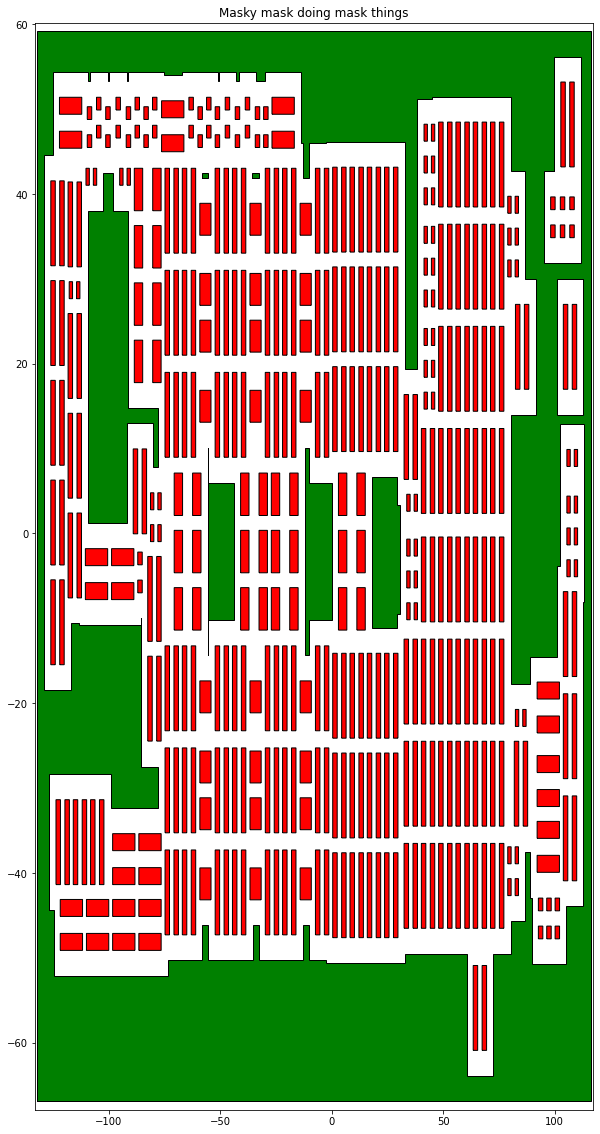

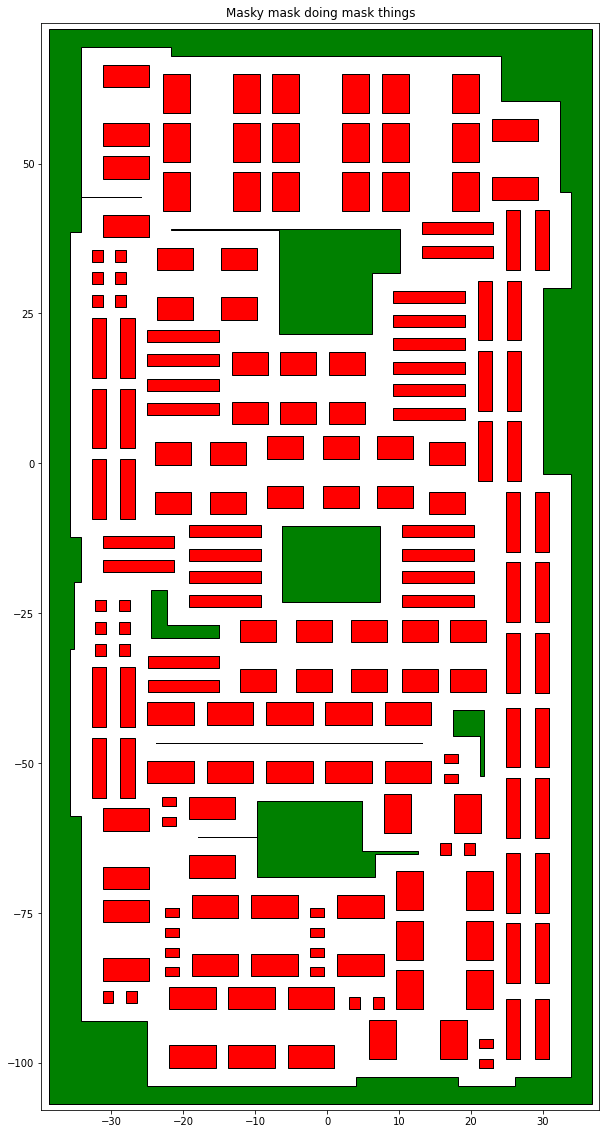

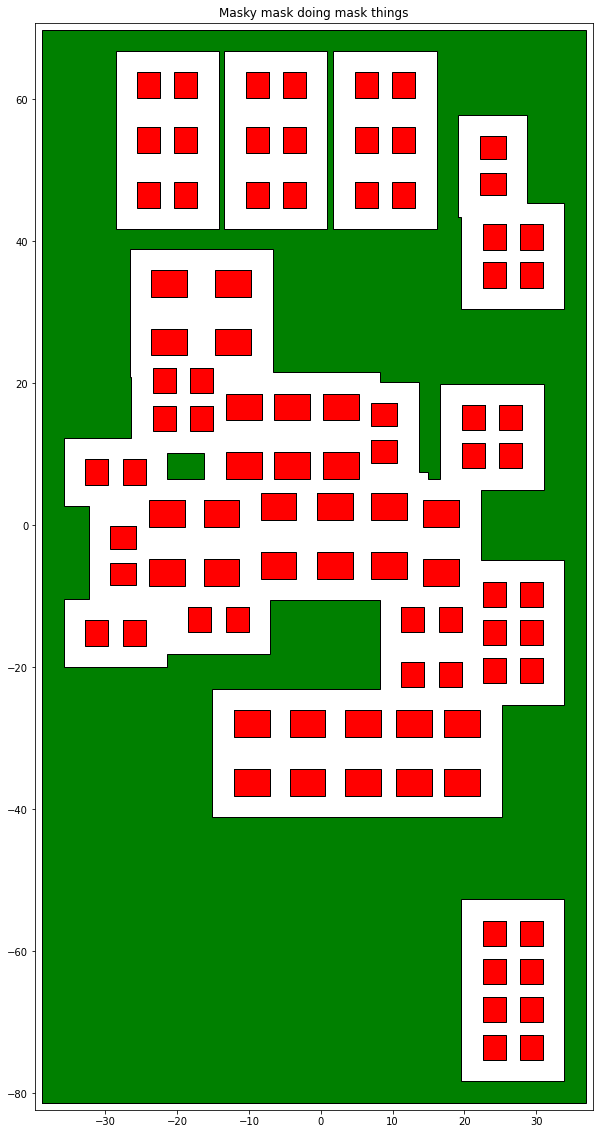

In [177]:
# Search the folder for 
root = r"E:\Scripting\MACD\MACD\TCB"
dxfs = os.listdir(os.path.join(root,"Examples"))
for dxf in dxfs[:3]:
    processdxf(dxf,3)


220 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


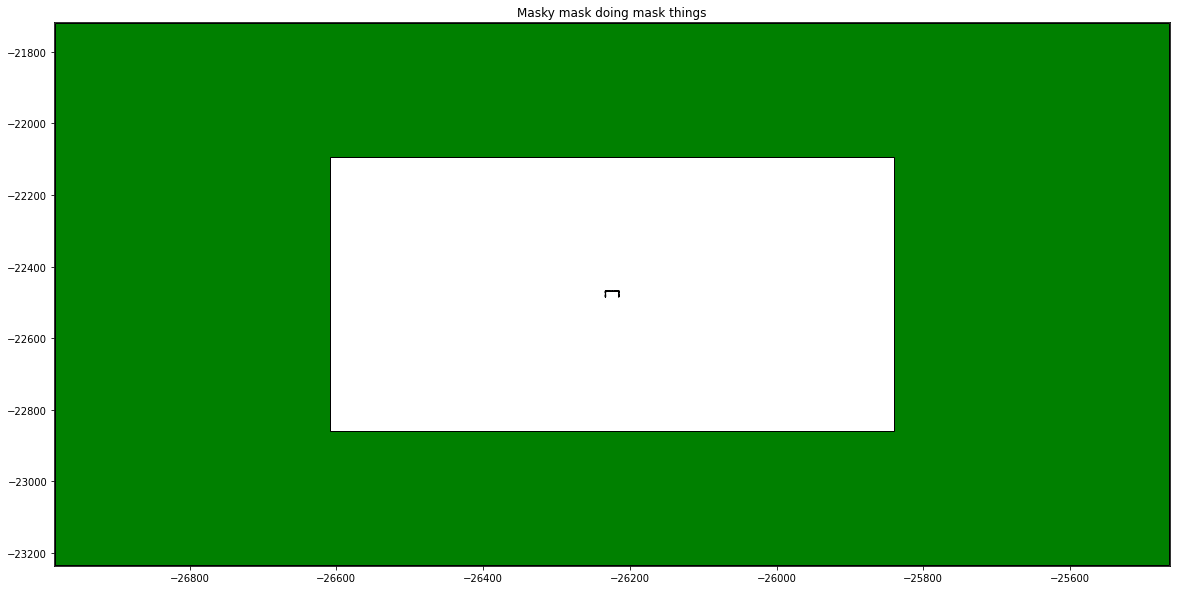

In [19]:
# fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M37813-001_BSR_r01 ww22.dxf"
# fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
# fn = r"E:\Scripting\dxf\input_example.dxf"
rawdxf = loaddxf(fn)
rawdxf.process()
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
squarebound = True
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz,squarebound)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together

Package Outline: 
220 objects have been found on BSR layer.
Completed mapping to dataframes df
Completed loading all the data
Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


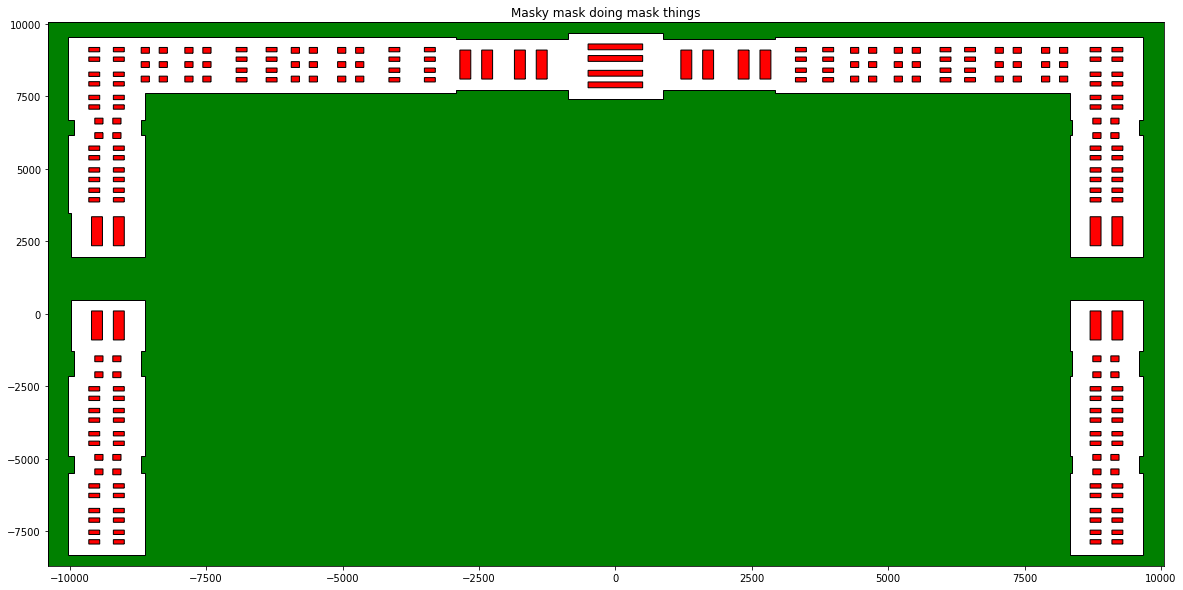

In [72]:
fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M55024-001_BSR_r01.dxf"
# fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
# fn = r"E:\Scripting\dxf\input_example.dxf"
rawdxf = loaddxf(fn)
rawdxf.process()
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together


Package Outline: 
220 objects have been found on BSR layer.
Completed mapping to dataframes df
Completed loading all the data


In [39]:

cmp_koz = 0.5 # Scaler
group_koz = 1 # Adder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()

Running mask script
created component mask with: Expand = 0.5 and 1x outline.
Completed


c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


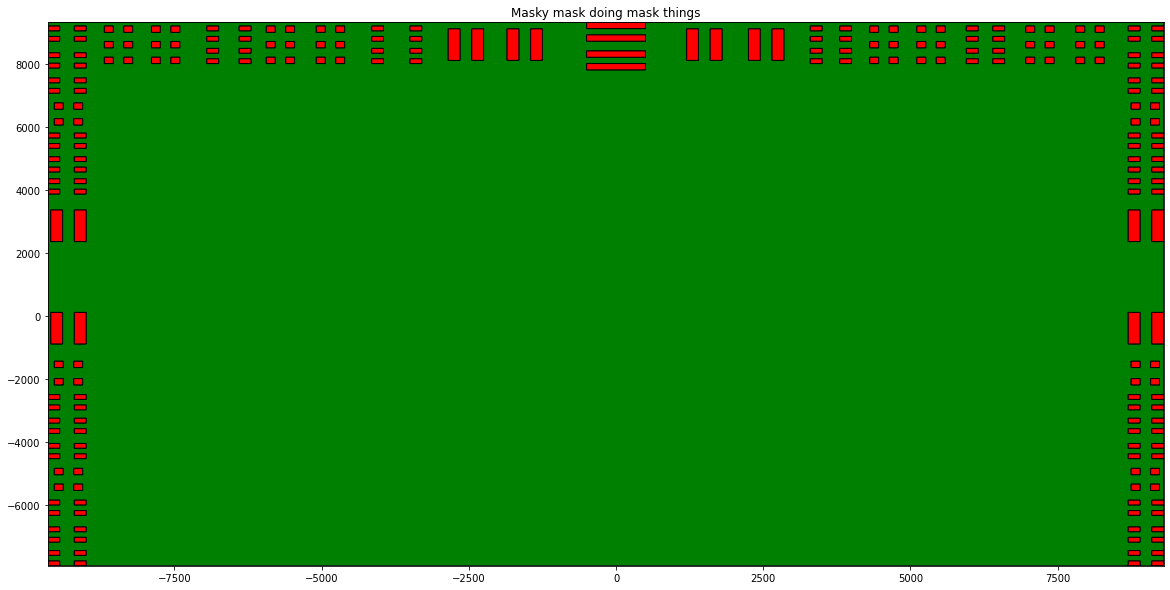

In [46]:
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together

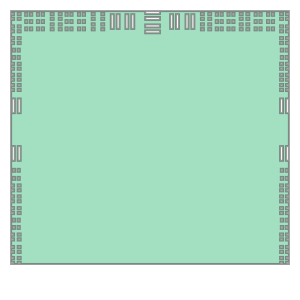

In [56]:
masks.diff_mask

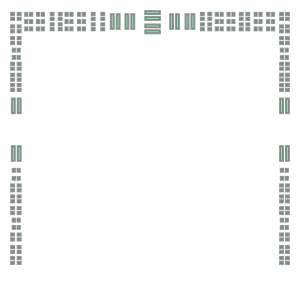

In [57]:
masks.cmp_mask

Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


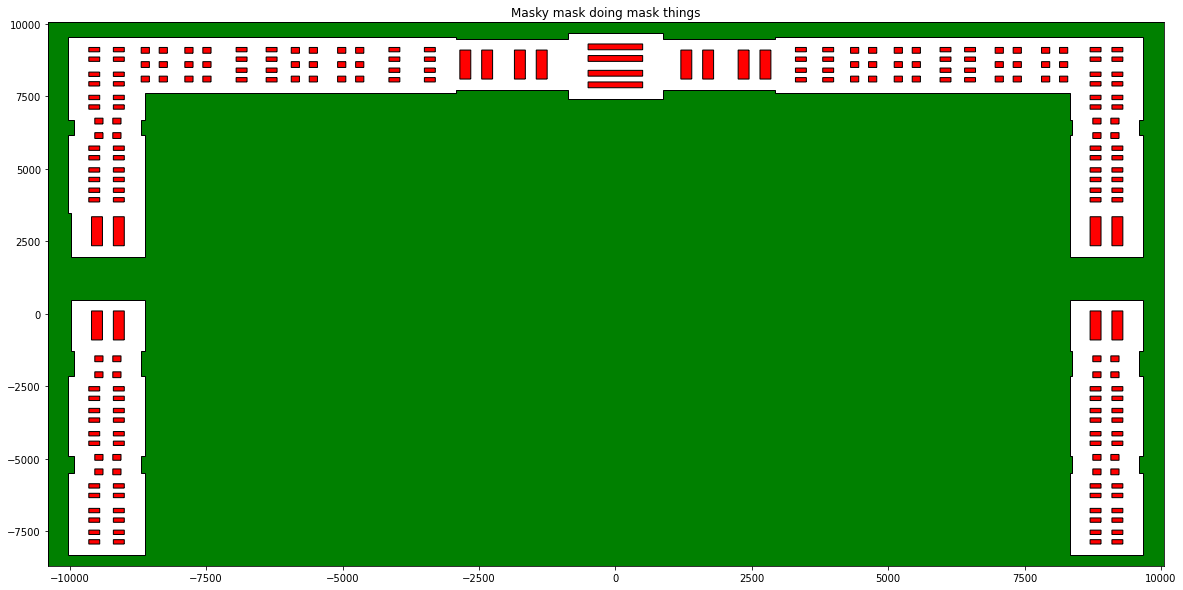

In [71]:
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together

In [3]:
#%%
# Created 7/5/2023 by Michael Tan & Josh Green
# Utilized for importing DXF shapes (curated file), generating a mask, than outputting a dxf
# Parsing DXF
import ezdxf as ez
# Maths
import numpy as np
import pandas as pd
# Shapes
import shapely.geometry as spg
from shapely.ops import unary_union, polygonize
from descartes import PolygonPatch
from shapely import affinity
# Plotting
import pylab as pl
# Misc
import os
import JigStreet as mf
import matplotlib.pyplot as plt

# %%
root = r"E:\Scripting\MACD\MACD\TCB"
dwgs = os.listdir(os.path.join(root,"Examples"))
# %%
#fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M25268-001_BSR_LLT_r02-Scaled.dxf"
fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M54481-001_BSR_r01-Scaled.dxf"
# fn = r"E:\Scripting\dxf\input_example.dxf"
derp = mf.loaddxf(fn)
derp.process()

Package Outline: 
92 objects have been found on BSR layer.
did it save?
Completed mapping to dataframes df
Completed loading all the data


In [4]:
derp.df_full

,CNAME,X,Y,P1X,P1Y,P2X,P2Y,P3X,P3Y,P4X,P4Y
0,D7,-12489.380,-24968.800,-12489.54,-24968.98,-12489.22,-24968.98,-12489.22,-24968.62,-12489.54,-24968.62
1,D8,-12489.900,-24968.800,-12490.06,-24968.98,-12489.74,-24968.98,-12489.74,-24968.62,-12490.06,-24968.62
2,D9,-12485.110,-24969.670,-12485.29,-24969.83,-12484.93,-24969.83,-12484.93,-24969.51,-12485.29,-24969.51
3,DA,-12485.110,-24970.190,-12485.29,-24970.35,-12484.93,-24970.35,-12484.93,-24970.03,-12485.29,-24970.03
4,DB,-12484.570,-24982.350,-12484.73,-24982.53,-12484.41,-24982.53,-12484.41,-24982.17,-12484.73,-24982.17
...,...,...,...,...,...,...,...,...,...,...,...
87,1136,-12488.665,-24976.330,-12488.83,-24976.51,-12488.50,-24976.51,-12488.50,-24976.15,-12488.83,-24976.15
88,1137,-12488.460,-24977.795,-12488.71,-24977.98,-12488.21,-24977.98,-12488.21,-24977.61,-12488.71,-24977.61
89,1138,-12488.460,-24978.620,-12488.71,-24978.81,-12488.21,-24978.81,-12488.21,-24978.43,-12488.71,-24978.43
90,1139,-12487.690,-24977.795,-12487.94,-24977.98,-12487.44,-24977.98,-12487.44,-24977.61,-12487.94,-24977.61


In [5]:
df_m1 = pd.melt(derp.df_full, id_vars=['CNAME'], value_vars=['P1X', 'P2X', "P3X", "P4X"], value_name = "X")
df_m2 = pd.melt(derp.df_full, id_vars=['CNAME'], value_vars=['P1Y', 'P2Y', "P3Y", "P4Y"], value_name = "Y")
df_melt = pd.concat([df_m1,df_m2],axis=1)
df_points = df_melt[['X','Y']].values.tolist()

C:\Users\mtan\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


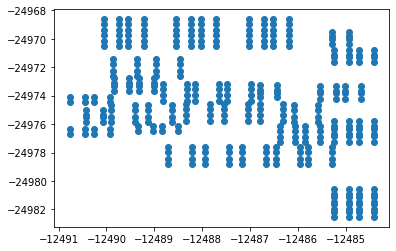

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=df_melt.X,y=df_melt.Y)

In [7]:
import alphashape


c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


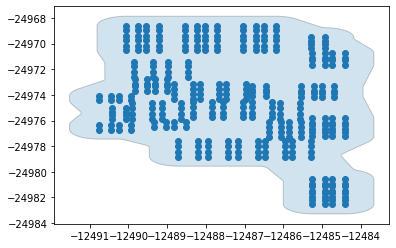

In [8]:
alpha_shape = alphashape.alphashape(df_points, 1.).buffer(1).buffer(-1)
alpha_shape
fig, ax = plt.subplots()
ax.scatter(*zip(*df_points))
ax.add_patch(PolygonPatch(alpha_shape.buffer(.75), alpha=0.2))
plt.show()


In [115]:
def chaikins_corner_cutting(coords, refinements=5):
    coords = np.array(coords)

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

In [117]:
ccp = chaikins_corner_cutting(df_points)

In [2]:
alpha_shape = alphashape.alphashape(ccp, 1.).buffer(2).buffer(-2)
alpha_shape
fig, ax = plt.subplots()
ax.scatter(*zip(*df_points))
ax.add_patch(PolygonPatch(alpha_shape.buffer(.5), alpha=0.2))
plt.show()

NameError: name 'alphashape' is not defined